# Évaluation du Pipeline : Détection et Identification
Ce notebook a pour but de quantifier les performances de notre système d'analyse de pièces de monnaie. 
L'évaluation se fait en 3 étapes strictes :
1. **Évaluation de la Détection :** Le système trouve-t-il les pièces (Précision, Rappel) ?
2. **Évaluation de l'Identification :** Quand une pièce est trouvée, son métal et sa valeur sont-ils corrects (Matrice de Confusion) ?
3. **Évaluation Globale (End-to-End) :** L'erreur finale sur la somme totale en euros par image.

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Pour avoir une belle barre de progression

# Importation de nos propres modules (les fichiers .py doivent être dans le même dossier)
# Assure-toi d'avoir renommé ton fichier de détection en 'coin_detector.py'
from coin_detector import CoinDetection
from coin_identification import CoinIdentification

# Configuration esthétique pour les graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Initialisation de nos classes
detector = CoinDetection(target_width=800)
# Attention: on désactive le KNN puisqu'il est optionnel et non utilisé dans la méthode finale
identifier = CoinIdentification(use_knn=False) 

# CHEMIN VERS LES IMAGES
IMAGE_DIR = './data/'

### 1. Chargement et Nettoyage de la Vérité Terrain
Nous chargeons le fichier CSV. Comme les valeurs en euros peuvent parfois être écrites avec des virgules (ex: "2,55" au lieu de "2.55"), nous nettoyons la colonne pour être sûrs d'avoir des chiffres précis.

In [8]:
# Chargement du fichier CSV
df_gt = pd.read_csv('ground_truth.csv')

# Nettoyage de la colonne 'value_eur' (remplacement des virgules, suppression des espaces, conversion en float)
df_gt['value_eur'] = df_gt['value_eur'].astype(str).str.replace(',', '.').str.replace('€', '').str.strip()

# Remplacement des valeurs vides éventuelles par 0 et conversion en décimal
df_gt['value_eur'] = pd.to_numeric(df_gt['value_eur'], errors='coerce').fillna(0.0)

# On retire les lignes où il y a 0 pièce (si applicable)
df_gt = df_gt[df_gt['num_coins'] > 0].reset_index(drop=True)

print(f"Vérité terrain chargée : {len(df_gt)} images à évaluer.")
display(df_gt.head())

Vérité terrain chargée : 106 images à évaluer.


,filename,num_coins,value_eur,group
0,18.png,7,4.31,gp1
1,19.png,4,1.60,gp1
2,20.png,8,4.81,gp1
3,21.png,6,3.76,gp1
4,22.png,5,2.25,gp1


### 2. Exécution du Pipeline sur l'ensemble du Dataset
Nous allons maintenant boucler sur toutes les images du CSV, lancer la Détection puis l'Identification, et stocker nos prédictions.
*(Cette étape peut prendre un peu de temps selon le nombre d'images).*

In [9]:
results = []

for index, row in tqdm(df_gt.iterrows(), total=len(df_gt), desc="Traitement des images"):
    # On reconstruit le chemin de l'image (en supposant qu'elles sont dans des sous-dossiers par groupe)
    # Ex: ./data/gp1/18.png
    img_path = os.path.join(IMAGE_DIR, str(row['group']), str(row['filename']))
    
    # Si le chemin avec le groupe ne marche pas, on essaie sans
    if not os.path.exists(img_path):
        img_path = os.path.join(IMAGE_DIR, str(row['filename']))
        
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Attention: Image introuvable -> {img_path}")
        continue
        
    # --- 1. DÉTECTION ---
    img_resized, scale = detector.preprocess(img)
    bg_info = detector.analyse_background(img_resized)
    detected_coins = detector.detect(img_resized, bg_info)
    
    # --- 2. IDENTIFICATION ---
    if len(detected_coins) > 0:
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2Lab)
        
        # Classification de chaque pièce
        for c in detected_coins:
            identifier.classify_one(hsv, lab, c, bg_info)
            
        # Assignation des valeurs finales
        final_coins = identifier.assign_denominations(detected_coins)
        
        # Calcul des totaux prédits
        pred_num_coins = len(final_coins)
        pred_value = sum(c['value'] for c in final_coins)
    else:
        pred_num_coins = 0
        pred_value = 0.0

    # Sauvegarde des résultats
    results.append({
        'filename': row['filename'],
        'group': row['group'],
        'true_coins': row['num_coins'],
        'pred_coins': pred_num_coins,
        'true_value': row['value_eur'],
        'pred_value': pred_value
    })

# Transformation en DataFrame pour l'analyse
df_res = pd.DataFrame(results)
print("Traitement terminé ! Aperçu des résultats :")
display(df_res.head())

Traitement des images: 100%|██████████| 106/106 [00:15<00:00,  6.95it/s]

Traitement terminé ! Aperçu des résultats :


,filename,group,true_coins,pred_coins,true_value,pred_value
0,18.png,gp1,7,7,4.31,3.63
1,19.png,gp1,4,4,1.60,1.75
2,20.png,gp1,8,8,4.81,4.51
3,21.png,gp1,6,6,3.76,2.91
4,22.png,gp1,5,5,2.25,3.20


### 3. Métriques de Détection : Précision et Rappel (Comptage)
Puisque nous n'avons pas les coordonnées des pièces dans la vérité terrain, nous évaluons la détection sur le comptage :
* **Vrais Positifs (TP) :** Les pièces correctement trouvées (Min entre Prédites et Vraies).
* **Faux Positifs (FP) :** Les cercles hallucinés en trop.
* **Faux Négatifs (FN) :** Les pièces ratées par le détecteur.

In [10]:
# Calcul des statistiques au niveau du dataset global
total_true = df_res['true_coins'].sum()
total_pred = df_res['pred_coins'].sum()

# Pour chaque image, TP = min(Vrai, Prédit)
TP = df_res.apply(lambda row: min(row['true_coins'], row['pred_coins']), axis=1).sum()

# FP = Si on a prédit plus que la vérité (hallucinations)
FP = df_res.apply(lambda row: max(0, row['pred_coins'] - row['true_coins']), axis=1).sum()

# FN = Si on a raté des pièces
FN = df_res.apply(lambda row: max(0, row['true_coins'] - row['pred_coins']), axis=1).sum()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("--- PERFORMANCE DE DÉTECTION (COMPTAGE) ---")
print(f"Total des vraies pièces : {total_true}")
print(f"Total des pièces trouvées (TP) : {TP}")
print(f"Pièces manquées (Faux Négatifs) : {FN}")
print(f"Fausses alertes (Faux Positifs) : {FP}\n")
print(f"➤ PRÉCISION : {precision*100:.2f}% (Fiabilité de nos détections)")
print(f"➤ RAPPEL    : {recall*100:.2f}% (Capacité à ne rater aucune pièce)")
print(f"➤ F1-SCORE  : {f1_score*100:.2f}%")

--- PERFORMANCE DE DÉTECTION (COMPTAGE) ---
Total des vraies pièces : 1107
Total des pièces trouvées (TP) : 930
Pièces manquées (Faux Négatifs) : 177
Fausses alertes (Faux Positifs) : 24

➤ PRÉCISION : 97.48% (Fiabilité de nos détections)
➤ RAPPEL    : 84.01% (Capacité à ne rater aucune pièce)
➤ F1-SCORE  : 90.25%


### 4. Évaluation Financière (MAE : Erreur Absolue Moyenne)
Au-delà du nombre de pièces, notre but ultime est d'avoir la bonne somme en euros. 
Nous allons calculer la **MAE** : en moyenne, de combien de centimes notre algorithme se trompe-t-il par image ?
Nous allons également tracer un graphique de régression (Vraie Valeur VS Valeur Prédite).

Erreur Financière Moyenne (MAE) : 1.77 € par image


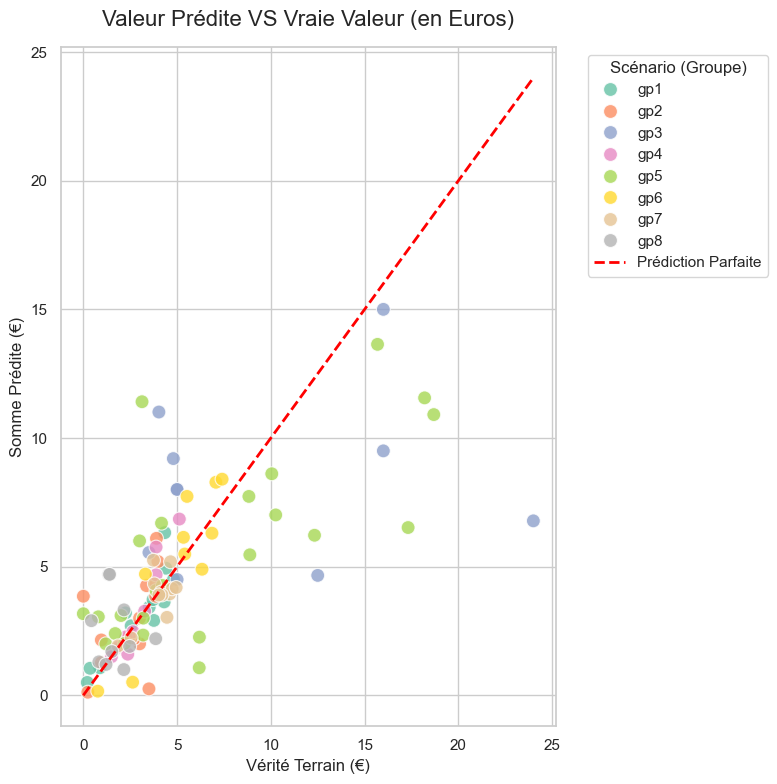

In [11]:
# Calcul de l'erreur absolue pour chaque image
df_res['error_eur'] = abs(df_res['true_value'] - df_res['pred_value'])

mae = df_res['error_eur'].mean()
print(f"Erreur Financière Moyenne (MAE) : {mae:.2f} € par image")

# Graphique de Régression
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_res, x='true_value', y='pred_value', hue='group', s=100, alpha=0.8, palette='Set2')

# Ligne rouge de prédiction parfaite (y = x)
max_val = max(df_res['true_value'].max(), df_res['pred_value'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Prédiction Parfaite')

plt.title('Valeur Prédite VS Vraie Valeur (en Euros)', fontsize=16, pad=15)
plt.xlabel('Vérité Terrain (€)', fontsize=12)
plt.ylabel('Somme Prédite (€)', fontsize=12)
plt.legend(title='Scénario (Groupe)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 5. Analyse de Robustesse : Performances par Scénario (Group)
La vraie force d'un algorithme de traitement d'image n'est pas sa moyenne générale, mais sa robustesse face à la difficulté. 
Notre dataset est divisé en groupes (gp1, gp2, gp3...) représentant différents niveaux de complexité (fonds colorés, sombres, pièces collées). Observons où notre pipeline excelle et où il faiblit.

,group,MAE_Euros,Total_Images,Exactitude_Comptage_%
0,gp1,0.50,14,64.29
1,gp2,1.02,15,40.00
2,gp3,5.25,10,60.00
3,gp4,0.56,10,70.00
4,gp5,3.01,25,32.00
5,gp6,1.14,10,90.00
6,gp7,0.58,12,83.33
7,gp8,1.43,10,50.00


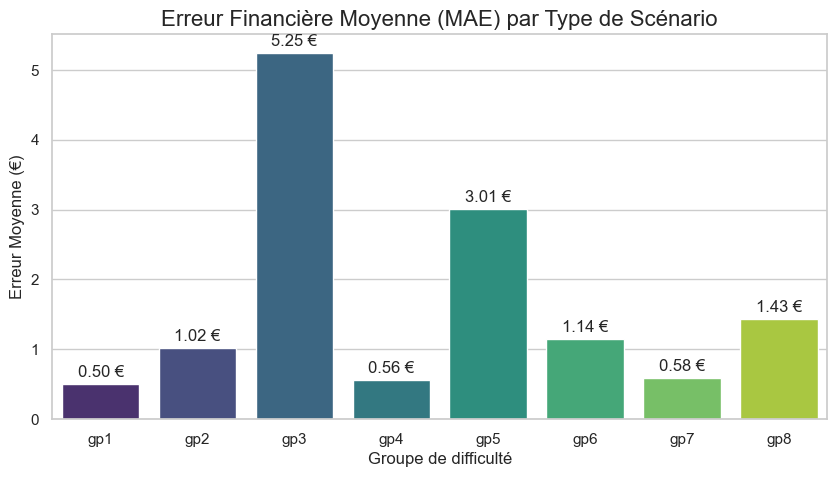

In [12]:
# On calcule l'erreur moyenne et l'exactitude du comptage par groupe
group_stats = df_res.groupby('group').agg(
    MAE_Euros=('error_eur', 'mean'),
    Total_Images=('filename', 'count')
).reset_index()

# On calcule aussi le pourcentage d'images où le comptage de pièces est 100% exact
df_res['count_perfect'] = (df_res['true_coins'] == df_res['pred_coins']).astype(int)
count_acc = df_res.groupby('group')['count_perfect'].mean() * 100
group_stats['Exactitude_Comptage_%'] = count_acc.values

display(group_stats.round(2))

# Graphique de l'Erreur MAE par Groupe
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=group_stats, x='group', y='MAE_Euros', palette='viridis')

# Ajout des valeurs sur les barres
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f €', padding=3)

plt.title('Erreur Financière Moyenne (MAE) par Type de Scénario', fontsize=16)
plt.xlabel('Groupe de difficulté', fontsize=12)
plt.ylabel('Erreur Moyenne (€)', fontsize=12)
plt.show()

In [13]:
# --- CALCULS POUR LE BILAN GLOBAL (DÉTECTION + IDENTIFICATION) ---

total_images = len(df_res)

# 1. Exactitude du comptage (Détection)
exact_count_matches = df_res[df_res['true_coins'] == df_res['pred_coins']].shape[0]
count_accuracy = (exact_count_matches / total_images) * 100

# 2. Exactitude financière (Le but ultime du projet)
# On utilise < 0.01 au lieu de == pour éviter les bugs d'arrondis des floats en Python
exact_value_matches = df_res[abs(df_res['true_value'] - df_res['pred_value']) < 0.01].shape[0]
value_accuracy = (exact_value_matches / total_images) * 100

# 3. Totaux financiers sur tout le dataset
total_true_eur = df_res['true_value'].sum()
total_pred_eur = df_res['pred_value'].sum()

print("=========================================================")
print("          BILAN FINAL DU PROJET (END-TO-END)             ")
print("=========================================================")
print(f"Nombre total d'images évaluées : {total_images}\n")

print("--- 1. PERFORMANCE DE DÉTECTION (COMPTAGE) ---")
print(f"Total des pièces réelles : {df_res['true_coins'].sum()}")
print(f"Total des pièces vues    : {df_res['pred_coins'].sum()}")
print(f"➤ EXACTITUDE COMPTAGE    : {count_accuracy:.2f} % (Images avec le compte parfait)")

print("\n--- 2. PERFORMANCE FINANCIÈRE (IDENTIFICATION) ---")
print(f"Somme totale réelle sur le dataset : {total_true_eur:.2f} €")
print(f"Somme totale calculée par l'algo   : {total_pred_eur:.2f} €")
print(f"Écart financier global absolu      : {abs(total_true_eur - total_pred_eur):.2f} €")
print(f"➤ EXACTITUDE FINANCIÈRE GLOBALE    : {value_accuracy:.2f} % (Images avec le total en euros PARFAIT)")

print("\n--- 3. TAUX D'ERREUR (MAE) ---")
print(f"➤ ERREUR MOYENNE PAR IMAGE : {mae:.2f} €")
print("=========================================================")

          BILAN FINAL DU PROJET (END-TO-END)             
Nombre total d'images évaluées : 106

--- 1. PERFORMANCE DE DÉTECTION (COMPTAGE) ---
Total des pièces réelles : 1107
Total des pièces vues    : 954
➤ EXACTITUDE COMPTAGE    : 56.60 % (Images avec le compte parfait)

--- 2. PERFORMANCE FINANCIÈRE (IDENTIFICATION) ---
Somme totale réelle sur le dataset : 490.50 €
Somme totale calculée par l'algo   : 465.26 €
Écart financier global absolu      : 25.24 €
➤ EXACTITUDE FINANCIÈRE GLOBALE    : 6.60 % (Images avec le total en euros PARFAIT)

--- 3. TAUX D'ERREUR (MAE) ---
➤ ERREUR MOYENNE PAR IMAGE : 1.77 €
